In [1]:
import pandas as pd
import numpy as np
import os
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

## Getting the data

Before you run this, make sure that you have generated a sliding_windows file by running 01_sliding_windows.

In [2]:
data_path = '../data/'

In [115]:
final_sliding_windows = pd.read_csv(data_path + '/sliding_windows_Thingy_smallest20_size20_step20.csv')
final_sliding_windows = pd.read_csv(data_path + '/sliding_windows_Respeck_smallest20_size20_step20.csv')

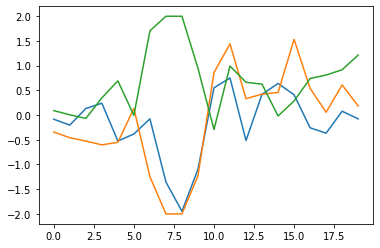

In [116]:
def plot_by_id(df, i): 
    plot_recording = df[df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
     
plot_by_id(final_sliding_windows, 'Respeck_s1865457_Falling on the back_30-09-2021_11-53-32')

## Split into training and test sets

Make sure to split by subject!

Take care if you have overlapping windows - this will need changing. 

In [97]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [98]:
# Simple for now
subjects = final_sliding_windows['subject_id'].unique()

train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, train_size=0.8)

X_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + columns_of_interest]
y_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + ['activity_type']]

X_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + columns_of_interest]
y_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + ['activity_type']]


## Format the input

Format data into windows - make (50,6) inputs

In [99]:
class_labels = {
    'Sitting': 0,
    'Sitting bent forward': 1,
    'Sitting bent backward': 2,
    'Standing': 3,
    'Lying down left': 4,
    'Lying down right': 5,
    'Lying down on stomach': 6,
    'Lying down on back': 7,
    'Walking at normal speed': 8,
    'Running': 9,
    'Climbing stairs': 10,
    'Descending stairs': 11,
    'Desk work': 12,
    'Movement': 13,
    'Falling on knees': 14,
    'Falling on the back': 15,
    'Falling on the left': 16,
    'Falling on the right': 17
}

In [100]:
# Keep only the classes of interest
X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
X_test_full = X_test_full[y_test_full['activity_type'].isin(class_labels.keys())]
y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
y_test_full = y_test_full[y_test_full['activity_type'].isin(class_labels.keys())]

# Create the y ones
y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
y_test = y_test_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values

y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)

In [101]:
X_train = []
X_test = []
    
for window_id, group in X_train_full.groupby('window_id'):
    #print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    #print(f"shape = {shape}")
    if shape == (20,6):
        X_train.append(group[columns_of_interest].values)
    
for window_id, group in X_test_full.groupby('window_id'):
    #print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    #print(f"shape = {shape}")
    
    X_test.append(group[columns_of_interest].values)
    
X_train = np.asarray(X_train)#, dtype=object)
X_test = np.asarray(X_test)#, dtype=object)

In [102]:
print(np.shape(X_train))
print(np.shape(X_test))

print(np.shape(y_train))
print(np.shape(y_test))

(23446, 20, 6)
(5342, 20, 6)
(23446, 18)
(5342, 18)


## Prepping the model

In [103]:
filters = 64
kernel_size = 3
n_features = 6
activation ='relu'
n_classes = len(class_labels)
window_size = 20
#filters = [3, 7, 11]

In [104]:
tf.random.set_seed(1)

model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 18, 64)            1216      
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 64)            256       
_________________________________________________________________
activation_9 (Activation)    (None, 18, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 64)            256       
_________________________________________________________________
activation_10 (Activation)   (None, 16, 64)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 14, 64)           

In [105]:
model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])

## Training the model

In [106]:
model.fit(X_train, y_train, batch_size=100, epochs=10)

Train on 23446 samples
Epoch 1/10
23446/23446 [==============================] - 6s 255us/sample - loss: 1.7236 - accuracy: 0.3939
Epoch 2/10
23446/23446 [==============================] - 4s 184us/sample - loss: 1.1929 - accuracy: 0.5817
Epoch 3/10
23446/23446 [==============================] - 4s 178us/sample - loss: 1.0287 - accuracy: 0.6297
Epoch 4/10
23446/23446 [==============================] - 4s 181us/sample - loss: 0.9381 - accuracy: 0.6578
Epoch 5/10
23446/23446 [==============================] - 4s 183us/sample - loss: 0.8914 - accuracy: 0.6722
Epoch 6/10
23446/23446 [==============================] - 4s 182us/sample - loss: 0.8310 - accuracy: 0.6919
Epoch 7/10
23446/23446 [==============================] - 4s 184us/sample - loss: 0.7975 - accuracy: 0.7015
Epoch 8/10
23446/23446 [==============================] - 4s 180us/sample - loss: 0.7614 - accuracy: 0.7119
Epoch 9/10
23446/23446 [==============================] - 4s 181us/sample - loss: 0.7337 - accuracy: 0.7197
Epoch

## Testing the model

In [107]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [108]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       335
           1       0.34      0.26      0.30       298
           2       0.19      0.24      0.21       297
           3       0.88      0.87      0.88       298
           4       0.83      0.62      0.71       298
           5       0.89      1.00      0.94       297
           6       0.85      0.75      0.80       297
           7       0.28      0.75      0.41       299
           8       0.76      0.82      0.79       334
           9       0.88      0.99      0.93       332
          10       0.90      0.85      0.87       333
          11       0.68      0.79      0.73       332
          12       0.12      0.05      0.07       298
          13       0.63      0.52      0.57       334
     

In [109]:
confusion_matrix = tf.math.confusion_matrix(
    y_true_labels, y_pred_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

<AxesSubplot:>

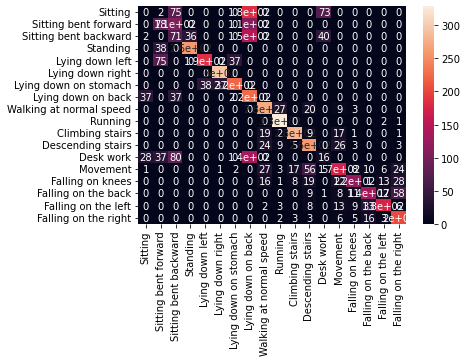

In [110]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())

### Accuracy of the subset

In [111]:
 groups = {
     'Sitting/Standing': [0,1,2,3,12], # including desk work
     'Lying': [4,5,6,7],
     'Walking': [8,10,11,13], # I include up and down stairs in this one + movement
     'Running': [9],
     'Falling': [14,15,16,17]
 }

In [112]:
def group_y(y):
    grouped_y = []
    for yy in y:
        group = [i for i,v in enumerate(groups.values()) if yy in v][0]
        grouped_y.append(group)
    return grouped_y

In [113]:
grouped_y_true_labels = group_y(y_true_labels)
grouped_y_pred_labels = group_y(y_pred_labels)

In [114]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(grouped_y_true_labels, grouped_y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      1526
           1       0.64      0.87      0.74      1191
           2       0.91      0.92      0.92      1333
           3       0.88      0.99      0.93       332
           4       0.93      0.87      0.90       960

    accuracy                           0.82      5342
   macro avg       0.84      0.85      0.84      5342
weighted avg       0.84      0.82      0.82      5342



### Save a test intance

In [107]:
for i in range(5):
    print(y_test[i])
    #np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [106]:
for i in np.arange(15,20):
    print(y_test[i])
    np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Save to file and convert to tflite

In [123]:
# Saving the model to file
model_name = 'cnn_simple_full_thingy'

export_dir = 'models\\' + model_name
tf.saved_model.save(model,export_dir)

# Convert the saved tensorflow model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the tensorflow lite model to file
import pathlib
tflite_model_file = pathlib.Path('models/' + model_name + '.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: models\cnn_simple_full_thingy\assets


473324